# Remaning Useful Life Estimation using TSFEL

On this example we will perform a Remaning Useful Life (RUL) estimation using our library Time Series Feature Extraction Library. <br><br>
To perform this example every cell must be executed. To do so click run ([ ]) in the top left of every cell. <br>

The first step consists of importing the library. To do that press play.

The import can take a few seconds, but the run button will change so that you know the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.


In [6]:
import sys
import os 

# Installation of last tsfel deployed version
!pip install https://github.com/fraunhoferportugal/tsfel/archive/v0.1.4.zip
sys.path.insert(0, './tsfel-development/')
import tsfel

import wget
import zipfile

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost

  Using cached https://github.com/fraunhoferportugal/tsfel/archive/v0.1.4.zip


## Auxiliary Methods

In [3]:
def fill_missing_values(df):
    """ Handle eventual missing data. Strategy: replace with mean.
    
      Parameters
      ----------
      df pandas DataFrame
      Returns
      -------
        Data Frame without missing values.
    """
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    return df

def mean_absolute_percentage_error(y_true, y_pred): 
    """ Calculate mean absolute percentage error between prediction and real values.
    
        Parameters
        -------
        y_true : List with real (test) values.
        y_pred : List with predicted values for some X
        Returns
        -------
        value mean absolute percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def read_cmapss_data(file_name):
    """ Read data from C-MAPSS dataset. Since all files have the same structure, a function can be defined to simplify the process
    
        Parameters
        -------
        file_name : File name
        Returns
        -------
        value mean absolute percentage
    """
    
    with open(file_name, "r") as file:
        lines = [line.rstrip() for line in file]
    return lines

The current iteration of tsfel doesn't allow for an overlap of just under 100%, that is, to have windows starting at consecutive values. 

Therefore, we implement a function that does exactly that.

In [5]:
# x_train_window for maximum overlap 
def signal_window_complete_overlap(df, window_size):
    """ window splitting, starting at consecutive values
        Parameters
        -------
        df : Pandas Dataframe 
        window_size : Size of the 
        Returns
        -------
        list with dataframes generated through 
    """
    
    data = []
    for i in range(df.shape[0]-window_size+1):
        data.append(df[i:i+window_size])
    return data

## Dataset

The dataset used for this example is the NASA C-MAPSS (https://core.ac.uk/download/pdf/10539072.pdf) dataset. It's the result of several simulations of real-life large commercial turbofan engines. Several tests are performed under different operating conditions. Each test follows a certain number of cycles until engine failure. 

The main objective of this dataset is to predict the Remaining Useful Life of an engine, using sensor measurements of several physical variables, such as temperature, pressure and fan speed.


It is particularly suited as an example for the capabilities of TSFEL for regression, since it requires us to predict a value for the RUL.

Get Nasa C-MAPSS dataset

In [8]:
wget.download("https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip")

100% [........................................................................] 12425978 / 12425978

'CMAPSSData.zip'

In [11]:
zip_ref = zipfile.ZipFile("CMAPSSData.zip", 'r')
zip_ref.extractall("C-MAPSS-Data")
zip_ref.close()

### Read train, test and RUL data from file

In [12]:
lines_train = read_cmapss_data("./C-MAPSS-Data/train_FD001.txt")
lines_test = read_cmapss_data("./C-MAPSS-Data/test_FD001.txt")
lines_rul = [int(i) for i in read_cmapss_data("./C-MAPSS-Data/RUL_FD001.txt")]

In [13]:
train = [line.split(" ") for line in lines_train]
test = [line.split(" ") for line in lines_test]

### Data cleanup

#### Define Overlap for windows 

In [14]:
overlap = 0.9
window_size = 30

In [15]:
# Move all data to dataframes
cols = ["id", "cycles", "setting1", "setting2", "setting3"]

for i in range(5, len(train[0])):
    cols.append("sensor" + str(i-5))

# Convert data to dataframes
data_train = pd.DataFrame(train, columns = cols)
data_test = pd.DataFrame(test, columns = cols)

# Convert columns to numeric
data_train[data_train.columns] = data_train[data_train.columns].apply(pd.to_numeric, errors='coerce', axis=1, downcast = "integer")
data_test[data_test.columns] = data_test[data_test.columns].apply(pd.to_numeric, errors='coerce', axis=1, downcast = "integer")

### Visualization

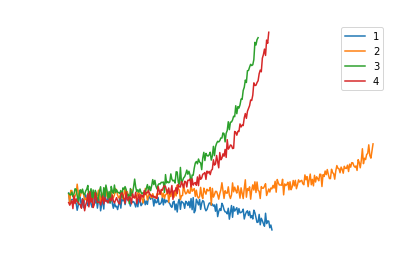

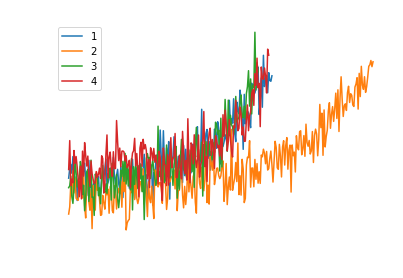

In [16]:
%matplotlib inline
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         "text.color" : "w",
         "legend.facecolor" : "w"}
plt.rcParams.update(params)

ids = [1,2,3,4]

plt.figure()
plt.subplot(1,1,1)
[plt.plot(data_train[data_train["id"] == i]["cycles"], data_train[data_train["id"] == i]["sensor13"]) for i in ids]
plt.xlabel("Cycles")
plt.ylabel("Fan flow (pps)")
plt.title("Sensor Value with increasing cycles")
legend = plt.legend(ids)
plt.setp(legend.get_texts(), color='black')
plt.show()

plt.subplot(1,1,1)
[plt.plot(data_train[data_train["id"] == i]["cycles"], data_train[data_train["id"] == i]["sensor3"]) for i in ids]
plt.xlabel("Cycles")
plt.ylabel("Total pressure at LPC outlet (psia)")
plt.title("Sensor Value with increasing cycles")
legend = plt.legend(ids)
plt.setp(legend.get_texts(), color='black')
plt.show()

### Separate Dataframe by experiment

In [17]:
x_train_sig_no_overlap = [data_train[data_train["id"] == i+1].drop(["id"], axis = 1) for i in range(int(max(set(list(data_train["id"])))))]
x_test_sig_no_overlap = [data_test[data_test["id"] == i+1].drop(["id"], axis = 1) for i in range(int(max(set(list(data_test["id"])))))]

# Number of cycles for each training and test experiment
nr_cycles_train = [df.shape[0] for df in x_train_sig_no_overlap]
nr_cycles_test = [df.shape[0] for df in x_test_sig_no_overlap]

### Create training and test instances using time windows

#### Train

In [18]:
X_train_sig = []
y_train = []

for i in range(len(x_train_sig_no_overlap)):
    x_train_create_overlaps = x_train_sig_no_overlap[i]
    
    # Allow for complete overlap 
    if overlap == 1:
        x_train_window = signal_window_complete_overlap(x_train_create_overlaps, window_size)    
    else:
        x_train_window = tsfel.signal_window_splitter(x_train_create_overlaps, window_size = window_size, overlap = overlap)
    
    for data in x_train_window:
        X_train_sig.append(data)
        y_train.append(nr_cycles_train[i] - data.iloc[-1,0])
    
X_train_sig = [i.drop(columns = ["cycles"], axis = 1) for i in X_train_sig]

#### Test

In [19]:
X_test_sig = []
y_test = []

for i in range(len(x_test_sig_no_overlap)):
    x_test_create_overlaps = x_test_sig_no_overlap[i]
    # Allow for complete overlap 
    if overlap == 1:
        x_test_window = signal_window_complete_overlap(x_test_create_overlaps, window_size)    
    else:
        x_test_window = tsfel.signal_window_splitter(x_test_create_overlaps, window_size = window_size, overlap = overlap)
    
    for data in x_test_window:
        X_test_sig.append(data)
        y_test.append(nr_cycles_test[i] - data.iloc[-1,0] + lines_rul[i])
    
X_test_sig = [i.drop(columns = ["cycles"], axis = 1) for i in X_test_sig]

### Feature extraction through TSFEL

Through Feature Extraction methodologies, the data is translated into a feature vector containing information about the signal properties of each window. These properties can be classified according to their domain as Time, Frequency and Statistical features and allow to characterise the signal compactly, enhancing its characteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

The features to extract are defined in the [google sheet](https://docs.google.com/spreadsheets/d/13u7L_5IX3XxFuq_SnbOZF1dXQfcBB0wR3PXhvevhPYA/edit?usp=sharing). Save a copy on your local drive and share it with featext@featext.iam.gserviceaccount.com.

Change your google sheet file name and the googleSheet_name variable to your name so both have the same name.

In [28]:
googleSheet_name = "Features_dev_cmapss"
cfg = tsfel.extract_sheet(googleSheet_name)

X_train = tsfel.time_series_features_extractor(cfg, X_train_sig, fs = 1, n_jobs = 8)
X_test = tsfel.time_series_features_extractor(cfg, X_test_sig, fs = 1, n_jobs = 8)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


Y labels are corrected to account for the fact that RUL is hard to determine for values above 125. <br>
A piecewise approximation is used in this case, with the target variable capped at 125. (Al-Dulaimi et al. [2019])<br>
That is: <br>
$ Y_{train/test} = Y_{actual}  $ if  $   Y_{actual} < 125$ <br>
$Y_{train/test} = 125, otherwise$

In [29]:
y_train = [min(i, 125) for i in y_train]
y_test = [min(i, 125) for i in y_test]

### Data Cleanup

In [30]:
X_train = fill_missing_values(X_train)
X_test = fill_missing_values(X_test)

nan_cols_train = [i for i in X_train.columns if X_train[i].isnull().any()]
X_train = X_train.drop(nan_cols_train, axis = 1)
X_test = X_test.drop(nan_cols_train, axis = 1)

X_train = X_train[X_test.columns]

Clean all features that are highly correlated with one another, as well as features with low variance, that should not help train the model.<br>
This uses the library's <i>correlated_features</i> function, as well as funcions from the sklearn package.

In [31]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
min_max_scaler = preprocessing.StandardScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

### PCA decomposition to remove amount of features
Due to the high amount of features that are generated by tsfel, especially for signal windows with high overlaps, a Principal Component Analysis decomposition is performed to retain a smaller percentage of variance and prevent overfitting

This was found to increase the quality of the prediction, especially in the case of high window overlap values.

(Don't use it if you want to be able to identify the most important features for the model after training.)

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1000)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")

Total explained variance: 0.9996232725412462


### Model training

#### XGBoost

In this example, the regression is performed by an XGBoost model, which, at the time of writing, is one of the top performing libraries to implement gradient boosting machines.

#### Hyperparameter tuning
The model's hyperparameters are tuned using a Randomized Search, alongside a stratified k-fold division, to ensure appropriate train/test division <br>
Since it takes some time to run (around 30 minutes for the current configuration), we suggest skipping this part and using the already tuned parameters

In [ ]:
params = {
    #"num_boost_round" : [10,25,50],
    "subsample" : [0.4,0.6,0.8,1.0],
    "colsaple_bytree" : [0.2, 0.4,0.6,0.8,1.0],
    "max_depth" : [2,3,4,5,6,7,8],
    'eta' : [0.02, 0.05, 0.1, 0.2, 0.3],
    "scale_pos_weight" : [1,2,5,10,50],
    "n_estimators" : [100, 200, 300]
}

xgb = xgboost.XGBRegressor(silent=False, objective="reg:squarederror")

folds = 5
param_comb = 60
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state=1001)

random_search = RandomizedSearchCV(xgb, param_distributions = params, n_iter = param_comb, n_jobs = 10, cv=skf.split(X_train ,Y_train), 
                                                                       verbose = 1, random_state = 1001)
random_search.fit(X_train, Y_train)

random_search.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 25.3min


#### Model Training

The following code trains the model, using a validation set obtained from the training dataset (90%-10%). The hyperparameters were chosen based on the hyperparameter tuning performed beforehand.

In [36]:
params = {'subsample': 0.6,
 'scale_pos_weight': 10,
 'n_estimators': 200,
 'max_depth': 6,
 'eta': 0.05,
 'njobs' : 10,
 'objective' : "reg:squarederror",
 'verbose' : 1}

xgb = xgboost.XGBModel(**params)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)

bst = xgb.fit(X_train, y_train,
             eval_metric = "rmse", early_stopping_rounds=10, eval_set=[(X_validation, y_validation)],
             verbose = True)

#xgboost.plot_importance(bst)

[17:02:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { njobs, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:86.98814
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:82.83433
[2]	validation_0-rmse:78.88743
[3]	validation_0-rmse:75.18626
[4]	validation_0-rmse:71.61208
[5]	validation_0-rmse:68.25693
[6]	validation_0-rmse:65.06002
[7]	validation_0-rmse:62.02371
[8]	validation_0-rmse:59.13372
[9]	validation_0-rmse:56.40477
[10]	validation_0-rmse:53.80282
[11]	validation_0-rmse:51.37233
[12]	validation_0-rmse:49.02930
[13]	validation_0-rmse:46.84058
[14]	validation_0-rmse:44.74246
[15]	validation_0-rmse:42.78772
[16]	validation_0-rmse:40.95436
[17]	vali

### RESULTS

#### Errors 
We analyze both the MAPE and the RMSE. In the literature, the RMSE, as well as a special scoring function (which is not presented here), are used.

The most common RMSE values in the literature are around 12/13 for novel models:
- DCNN: 12.61 (Ding et al. (2018) - https://doi.org/10.1016/j.ress.2017.11.021)
- FMLP: 13.36 (Wang et al. (2019) - https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8819420)
- Ensemble ResCNN: 12.16 (Wen et al. (2019) - https://www.aimspress.com/fileOther/PDF/MBE/mbe-16-02-040.pdf)

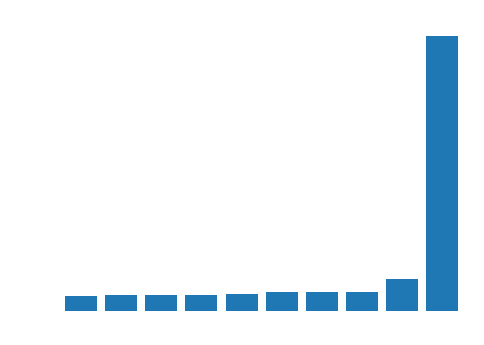

In [34]:
var_imp = bst.get_booster().get_score(importance_type="gain")
a = {k: v for k, v in sorted(var_imp.items(), key=lambda item:item[1])}

x=list(a.keys())
y=list(a.values())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.autofmt_xdate()
ax.bar(x[len(x)-10:len(x)], y[len(y)-10:len(y)])
ax.tick_params(axis="x", labelsize=10)
plt.title("Variable importance")
plt.show()

### Metrics

In [37]:
y_test_predict = bst.predict(X_test)

mape = mean_absolute_percentage_error(y_test_predict, y_test)
rmse = mean_squared_error(y_test_predict, y_test, squared = False)
print(f"With overlap {overlap}:\n\nMAPE: {mape}\n\nRMSE: {rmse}")

With overlap 0.9:

MAPE: 15.150342311306012

RMSE: 17.141447428473256


Even when used with low overlap values, the resulting model offers results very close to the ones established in literature.

#### Comparison of real and predicted RUL

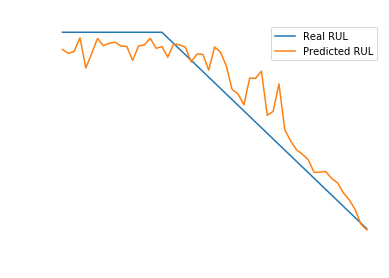

In [38]:
signals_real = []
signals_pred = []
is_larger = [False] + [y_test[i+1] > y_test[i] for i in range(0, len(y_test)-1)]

signals_real = []

j = 0
for i in range(len(y_test)):
    if is_larger[i]:
        j += 1
    try:
        signals_real[j]
        signals_pred[j]
    except:
        signals_real.append([])
        signals_pred.append([])
        
    signals_real[j].append(y_test[i])
    signals_pred[j].append(y_test_predict[i])
        
sig = 22
plt.figure()
plt.subplot(1,1,1)
plt.plot([i for i in range(len(signals_real[sig]))], signals_real[sig])
plt.plot([i for i in range(len(signals_pred[sig]))], signals_pred[sig])
plt.xlabel("Cycle")
plt.ylabel("RUL (in cycles)")
plt.title("Comparison of real and predicted RUL")
legend = plt.legend(["Real RUL", "Predicted RUL"])
plt.setp(legend.get_texts(), color='black')
plt.show()

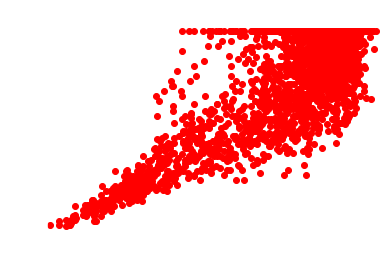

In [39]:
plt.figure()
plt.plot(y_test_predict, y_test , "ro")
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.xlabel("Predicted value")
plt.ylabel("Real value (adjusted)")
plt.title("Predicted vs. real value")
plt.show()